In [1]:
# GloVe + BiLstm + Dense neural network
import numpy as np 
import pandas as pd 
import os
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
# from keras.layers.experimental.preprocessing import Tokenizer
# from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [3]:
# data = pd.read_json("Sarcasm_Headlines_Dataset_1.json", lines=True)
data = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines=True)
# data =  pd.concat([data, data_2])
data.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [4]:
# BILSTM changes 

data.drop('article_link', axis = 1, inplace = True)
data.head()



,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
dtypes: int64(1), object(1)
memory usage: 447.3+ KB
None


In [6]:
data.drop_duplicates(subset=['headline'], inplace = True)
data.duplicated().sum()

0

In [7]:
data['headline'][10]

'this lesbian is considered a father in indiana (and an amazing one at that)'

In [8]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = emoji.sub(r'', text)
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)        
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text) 
    text = re.sub(r"\'ll", " will", text)  
    text = re.sub(r"\'ve", " have", text)  
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"did't", "did not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"have't", "have not", text)
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [9]:
data['headline'][10]

'this lesbian is considered a father in indiana (and an amazing one at that)'

In [10]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download()

nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

def cleantext(text):
    text = re.sub(r'\d+', '', text)
    text = "".join([char for char in text if char not in string.punctuation])
    return text

data['headline']=data['headline'].apply(cleantext)

# prev code

# def CleanTokenize(df):
#     head_lines = list()
#     lines = df["headline"].values.tolist()

#     for line in lines:
#         line = clean_text(line)
#         # tokenize the text
#         tokens = word_tokenize(line)
#         # remove puntuations
#         table = str.maketrans('', '', string.punctuation)
#         stripped = [w.translate(table) for w in tokens]
#         # remove non alphabetic characters
#         words = [word for word in stripped if word.isalpha()]
#         stop_words = set(stopwords.words("english"))
#         # remove stop words
#         words = [w for w in words if not w in stop_words]
#         head_lines.append(words)
#     return head_lines

# head_lines = CleanTokenize(data)
# head_lines[0:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
data['sentence_len'] = data['headline'].str.len()
data.head()

,is_sarcastic,headline,sentence_len
0,1,thirtysomething scientists unveil doomsday clo...,61
1,0,dem rep totally nails why congress is falling ...,77
2,0,eat your veggies deliciously different recipes,47
3,1,inclement weather prevents liar from getting t...,52
4,1,mother comes pretty close to using word stream...,59


In [12]:
max(data['sentence_len'])

910

In [13]:
max_features = 10000
maxlen = 300
embed_size = 200

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=max_features,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=' ', char_level=False)
tokenizer.fit_on_texts(data['headline'])

In [15]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(data['headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

In [16]:
vocab_size=len(tokenizer.word_index)
print (vocab_size)

28846


In [19]:
glove_file = 'glove/glove.6B.200d.txt'

In [20]:
embeddings = {}

for line in open(glove_file,  encoding = "utf-8"):
    word = line.split(" ")[0]
    embed = line.split(" ")[1:]
    embed = np.asarray(embed, dtype = 'float32')
    embeddings[word] = embed

In [21]:
embedding_matrix = np.zeros((vocab_size, 200))

# print(len(embeddings))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [22]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.57345998,  0.54170001, -0.23477   , ...,  0.54417998,
        -0.23069   ,  0.34946999],
       [ 0.052924  ,  0.25426999,  0.31353   , ..., -0.086254  ,
        -0.41916999,  0.46496001],
       ...,
       [ 0.56370002,  0.42438   ,  1.21969998, ..., -0.15029   ,
        -0.08155   , -0.1043    ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.53964001, -0.53973001, -0.41780999, ...,  0.23913001,
         0.51385999,  0.42449999]])

In [23]:
import tensorflow
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential

input_layer = Input(shape=(maxlen,),dtype=tensorflow.int64)
embed = Embedding(embedding_matrix.shape[0],output_dim=200,weights=[embedding_matrix],input_length=maxlen, trainable=True)(input_layer)
lstm=Bidirectional(LSTM(128))(embed)
drop=Dropout(0.3)(lstm)
dense =Dense(100,activation='relu')(drop)
out=Dense(2,activation='softmax')(dense)

In [24]:
model = Model(input_layer,out)
model.compile(loss='sparse_categorical_crossentropy',optimizer="adam",metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 200)          5769200   
                                                                 
 bidirectional (Bidirection  (None, 256)               336896    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 100)               25700     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                            

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [26]:
history = model.fit(X_train,y_train,batch_size=50, validation_data=(X_test, y_test), epochs=5, verbose=1)

Epoch 1/5


457/457 [==============================] - 364s 784ms/step - loss: 0.4257 - accuracy: 0.7964 - val_loss: 0.3309 - val_accuracy: 0.8537
Epoch 2/5
457/457 [==============================] - 365s 800ms/step - loss: 0.2494 - accuracy: 0.8985 - val_loss: 0.3102 - val_accuracy: 0.8758
Epoch 3/5
457/457 [==============================] - 387s 846ms/step - loss: 0.1567 - accuracy: 0.9401 - val_loss: 0.3587 - val_accuracy: 0.8611
Epoch 4/5
457/457 [==============================] - 385s 842ms/step - loss: 0.0959 - accuracy: 0.9643 - val_loss: 0.4393 - val_accuracy: 0.8644
Epoch 5/5
457/457 [==============================] - 389s 851ms/step - loss: 0.0611 - accuracy: 0.9790 - val_loss: 0.5015 - val_accuracy: 0.8542


In [27]:
import matplotlib.pyplot as plt 

def learning_curve(hist, epochs):

    epoch_range = range(1, 6)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()


    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

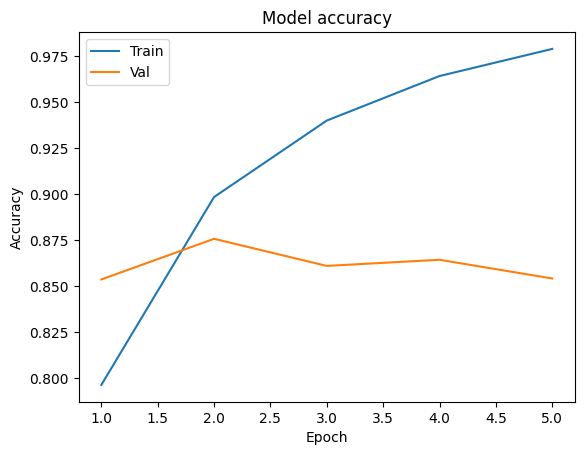

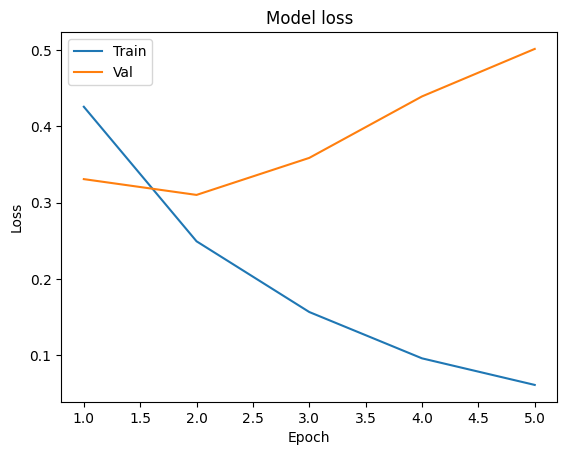

In [28]:
learning_curve(history, 6)

In [29]:
model.evaluate(X_test, y_test, verbose=0)

[0.5015279054641724, 0.8542361259460449]

In [30]:
y_pred = model.predict(np.array(X_test), verbose=1)
y_pred = [1 if j>i else 0 for i,j in y_pred]

179/179 [==============================] - 17s 85ms/step


In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[2718,  272],
       [ 559, 2152]], dtype=int64)

In [32]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      2990
           1       0.89      0.79      0.84      2711

    accuracy                           0.85      5701
   macro avg       0.86      0.85      0.85      5701
weighted avg       0.86      0.85      0.85      5701

